# __EXAMPLE__ (cifar_10, vgg16, ...)

Description & tasks

In [1]:
import itertools
import math 
import os
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.activations import mish, relu, sigmoid, softmax
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import losses
from keras import metrics
from keras import models
from keras import optimizers
from sklearn.model_selection import train_test_split


2023-09-11 22:32:48.619645: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-11 22:32:48.621979: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-11 22:32:48.685323: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-11 22:32:48.686600: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-11 22:32:49.813854: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

- https://www.w3schools.com/python/ref_random_seed.asp

In [2]:
def set_seed(seed_value: int) -> None:
    """Set a random state for repeatability of results."""
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    os.environ['TF_DETERMINISTIC_OPS'] = 'true'
    

set_seed(1)  # 42 from The Hitchhiker's Guide to the Galaxy ^_^

### __`OBTAIN` & `SCRUB`__ + __`EXPLORE`__ (DATASET)

- https://www.tensorflow.org/datasets/catalog/cifar10
- https://www.cs.toronto.edu/~kriz/cifar.html
- https://github.com/YoongiKim/CIFAR-10-images

In [73]:
PATH_IMGS = os.path.join(os.getcwd(), 'CIFAR-10-images-master', 'train')
PATH_TEST_IMGS = os.path.join(os.getcwd(), 'CIFAR-10-images-master', 'test')

cfg = {
       'train_limit': 500,  # limit 500 for each - for example
       'image_size': 32,
       'batch_size': 256,
       }

In [74]:
ids, ids_test = [], []  # full image paths
labels, labels_test = [], []  # true mark 'images name-description' by label2index:
label2index = {}

for num, folder in enumerate(os.listdir(PATH_IMGS)):
    label2index[folder] = num
    train_heap = os.listdir(os.path.join(PATH_IMGS, folder)) if cfg.get('train_limit') == 0 else os.listdir(os.path.join(PATH_IMGS, folder))[:cfg.get('train_limit')]
    for image_name in train_heap:  
        ids.append(os.path.join(PATH_IMGS, folder, image_name))
        labels.append(label2index[folder])

cfg['num_classes'] = num + 1
cfg.get('num_classes')

10

In [75]:
len(ids), len(labels)

(5000, 5000)

In [76]:
for num, folder in enumerate(os.listdir(PATH_TEST_IMGS)):
    test_heap = os.listdir(os.path.join(PATH_TEST_IMGS, folder)) if cfg.get('test_limit') == 0 else os.listdir(os.path.join(PATH_TEST_IMGS, folder))[:cfg.get('test_limit')]
    for image_name in test_heap:  
        ids_test.append(os.path.join(PATH_TEST_IMGS, folder, image_name))
        labels_test.append(label2index[folder])  # .get?

In [77]:
len(ids_test), len(labels_test)

(10000, 10000)

In [78]:
label2index

{'dog': 0,
 'ship': 1,
 'frog': 2,
 'automobile': 3,
 'bird': 4,
 'deer': 5,
 'truck': 6,
 'cat': 7,
 'airplane': 8,
 'horse': 9}

In [79]:
index2label = {y: x for x, y in label2index.items()}
index2label

{0: 'dog',
 1: 'ship',
 2: 'frog',
 3: 'automobile',
 4: 'bird',
 5: 'deer',
 6: 'truck',
 7: 'cat',
 8: 'airplane',
 9: 'horse'}

In [80]:
ids_train, ids_valid, y_train, y_valid = train_test_split(ids, labels, test_size=0.2, shuffle=True)
len(ids_train), len(ids_valid), len(y_train), len(y_valid)

(4000, 1000, 4000, 1000)

- https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence
- https://numpy.org/doc/stable/reference/random/generated/numpy.random.shuffle.html
- https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical

- https://docs.opencv.org/3.4/d4/da8/group__imgcodecs.html
- https://www.geeksforgeeks.org/python-opencv-cv2-imread-method/

In [11]:
class Dataset(tf.keras.utils.Sequence):
    def __init__(self, ids: list, y: list, num_classes: int, to_size: int, shuffle: bool=True, batch_size: int=256) -> None:
        self.ids = ids  # list of imgs path
        self.y = y  # list of labels ids (List[int])
        self.num_classes = num_classes
        self.to_size = to_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.ids))
        self.batch_size = batch_size
        self.num_features = self.num_features if self.__getitem__(0) else 0
        
        if shuffle:
            self.on_epoch_end()
    
    def __len__(self) -> int:
        return len(self.ids) // self.batch_size
    
    def __getitem__(self, idx: int) -> tuple:  # get one batch
        indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_ids = [self.ids[i] for i in indexes]
        batch_y = [tf.keras.utils.to_categorical(self.y[i], self.num_classes) for i in indexes]
        
        batch_X = []
        for i in range(self.batch_size):
            img = cv2.imread(batch_ids[i])  # i/o disk operation! but low RAM uses
            # img = np.mean(img, axis=-1)  # RGB to grayscale
            # img = np.mean(img, cv2.COLOR_BGR2RGB, axis=-1)  # RGB to grayscale
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            batch_X.append(cv2.resize(img, (self.to_size, self.to_size), interpolation=cv2.INTER_NEAREST))
            # batch_X.append(cv2.cvtColor(cv2.resize(img, (self.to_size, self.to_size), interpolation=cv2.INTER_NEAREST), cv2.COLOR_GRAY2RGB))
        
        self.num_features = len(img[0]) * len(img) # !!
        
        return np.array(batch_X), np.array(batch_y)
        
    def on_epoch_end(self) -> None:
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [92]:
train_dataset = Dataset(ids_train, y_train, num_classes=cfg.get('num_classes'), to_size=cfg.get('image_size'), shuffle=True, batch_size=cfg.get('batch_size'))
X, y = train_dataset[0]
X.shape, y.shape

((256, 32, 32, 3), (256, 10))

In [93]:
test_dataset = Dataset(ids_test, labels_test, num_classes=cfg.get('num_classes'), to_size=cfg.get('image_size'), shuffle=True, batch_size=cfg.get('batch_size'))
X_test, y_test = test_dataset[0]
X_test.shape, y_test.shape

((256, 32, 32, 3), (256, 10))

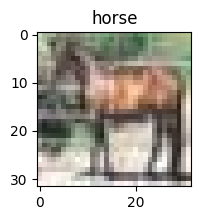

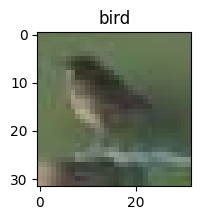

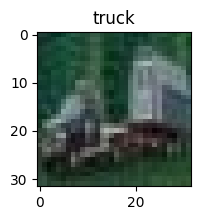

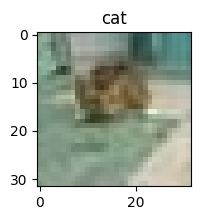

In [95]:
for i in range(4):
    plt.figure(figsize=(2, 2))
    plt.title(index2label[np.where(y[i] == 1)[0][0]])
    # plt.imshow(X[i].reshape(32, 32))
    plt.imshow(X[i])
    plt.show()

In [96]:
# train_dataset = Dataset(ids_train, y_train, shuffle=True, batch_size=cfg.get('batch_size'))
# train_dataset[0]
cfg['num_features'] = train_dataset.num_features
cfg.get('num_features')

1024

In [97]:
valid_dataset = Dataset(ids_valid, y_valid, num_classes=cfg.get('num_classes'), to_size=cfg.get('image_size'), shuffle=False, batch_size=cfg.get('batch_size'))

In [98]:
valid_dataset[0][0].shape  # (batch_size, num_features)

(256, 32, 32, 3)

#### fix Pre-preparation

In [3]:
PATH_IMGS = os.path.join(os.getcwd(), 'CIFAR-10-images-master', 'train')
PATH_TEST_IMGS = os.path.join(os.getcwd(), 'CIFAR-10-images-master', 'test')

cfg = {
       'train_limit': 500,  # limit 500 for each - for example
       'image_size': 32,
       'batch_size': 256,
       }

label2index = {}

In [4]:
ids, ids_test = [], []  # full image paths
labels, labels_test = [], []  # true mark 'images name-description' by label2index:


for num, folder in enumerate(os.listdir(PATH_IMGS)):
    label2index[folder] = num
    train_heap = os.listdir(os.path.join(PATH_IMGS, folder)) if cfg.get('train_limit') == 0 else os.listdir(os.path.join(PATH_IMGS, folder))[:cfg.get('train_limit')]
    for image_name in train_heap:  
        ids.append(os.path.join(PATH_IMGS, folder, image_name))
        labels.append(label2index[folder])

cfg['num_classes'] = num + 1
cfg.get('num_classes')

10

In [35]:
def pre_preparation_data(path_imgs: str, path_test_imgs: str) -> tuple:
    train_limit = cfg.get('train_limit')
    test_size = cfg.get('test_limit')
    ids, ids_test = [], []  # full image paths
    labels, labels_test = [], []  # true mark 'images name-description' by label2index:
    for num, folder in enumerate(os.listdir(path_imgs)):
        label2index[folder] = num
        train_heap = os.listdir(os.path.join(path_imgs, folder)) if train_limit == 0 else os.listdir(os.path.join(path_imgs, folder))[:train_limit]
        for image_name in train_heap:  
            ids.append(os.path.join(path_imgs, folder, image_name))
            labels.append(label2index[folder])
    
    cfg['num_classes'] = num + 1

    for num, folder in enumerate(os.listdir(path_test_imgs)):
        test_heap = os.listdir(os.path.join(path_test_imgs, folder)) if test_size == 0 else os.listdir(os.path.join(path_test_imgs, folder))[:test_size]
        for image_name in test_heap:  
            ids_test.append(os.path.join(path_test_imgs, folder, image_name))
            labels_test.append(label2index[folder])  # .get?         

    ids_train, _, y_train, __ = train_test_split(ids, labels, test_size=0.0001, shuffle=True)
    ids_valid, ids_test, y_valid, y_test = train_test_split(ids_test, labels_test, test_size=0.5, shuffle=True)   

    return ids_train, y_train, ids_valid, y_valid, ids_test, y_test

In [36]:
ids_train, labels_train, ids_valid, labels_valid, ids_test, labels_test = pre_preparation_data(PATH_IMGS, PATH_TEST_IMGS)
len(ids_train), len(labels_train), len(ids_valid), len(labels_valid), len(ids_test), len(labels_test)

(4999, 4999, 5000, 5000, 5000, 5000)

train_limit(500) * num_classes(10) = size(5000)

In [37]:
cfg.get('num_classes')

10

In [38]:
label2index

{'dog': 0,
 'ship': 1,
 'frog': 2,
 'automobile': 3,
 'bird': 4,
 'deer': 5,
 'truck': 6,
 'cat': 7,
 'airplane': 8,
 'horse': 9}

In [39]:
index2label = {y: x for x, y in label2index.items()}
index2label

{0: 'dog',
 1: 'ship',
 2: 'frog',
 3: 'automobile',
 4: 'bird',
 5: 'deer',
 6: 'truck',
 7: 'cat',
 8: 'airplane',
 9: 'horse'}

In [40]:
class Dataset(tf.keras.utils.Sequence):
    def __init__(self, ids: list, y: list, num_classes: int, to_size: int, shuffle: bool=True, batch_size: int=256) -> None:
        self.ids = ids  # list of imgs path
        self.y = y  # list of labels ids (List[int])
        self.num_classes = num_classes
        self.to_size = to_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.ids))
        self.batch_size = batch_size
        self.num_features = self.num_features if self.__getitem__(0) else 0
        
        if shuffle:
            self.on_epoch_end()
    
    def __len__(self) -> int:
        return len(self.ids) // self.batch_size
    
    def __getitem__(self, idx: int) -> tuple:  # get one batch
        indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_ids = [self.ids[i] for i in indexes]
        batch_y = [tf.keras.utils.to_categorical(self.y[i], self.num_classes) for i in indexes]
        
        batch_X = []
        for i in range(self.batch_size):
            img = cv2.imread(batch_ids[i])  # i/o disk operation! but low RAM uses
            # img = np.mean(img, axis=-1)  # RGB to grayscale
            # img = np.mean(img, cv2.COLOR_BGR2RGB, axis=-1)  # RGB to grayscale
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            batch_X.append(cv2.resize(img, (self.to_size, self.to_size), interpolation=cv2.INTER_NEAREST))
            # batch_X.append(cv2.cvtColor(cv2.resize(img, (self.to_size, self.to_size), interpolation=cv2.INTER_NEAREST), cv2.COLOR_GRAY2RGB))
        
        self.num_features = len(img[0]) * len(img) # !!
        
        return np.array(batch_X), np.array(batch_y)
        
    def on_epoch_end(self) -> None:
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [41]:
train_dataset = Dataset(ids_train, labels_train, num_classes=cfg.get('num_classes'), to_size=cfg.get('image_size'), shuffle=True, batch_size=cfg.get('batch_size'))
valid_dataset = Dataset(ids_valid, labels_valid, num_classes=cfg.get('num_classes'), to_size=cfg.get('image_size'), shuffle=False, batch_size=cfg.get('batch_size'))
test_dataset = Dataset(ids_test, labels_test, num_classes=cfg.get('num_classes'), to_size=cfg.get('image_size'), shuffle=True, batch_size=cfg.get('batch_size'))
X_test, y_test = test_dataset[0]
X_test.shape, y_test.shape, valid_dataset[0][0].shape, valid_dataset[0][1].shape, test_dataset[0][0].shape, test_dataset[0][1].shape

((256, 32, 32, 3),
 (256, 10),
 (256, 32, 32, 3),
 (256, 10),
 (256, 32, 32, 3),
 (256, 10))

In [42]:
cfg['num_features'] = train_dataset.num_features
cfg.get('num_features')

1024

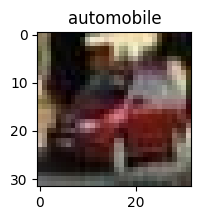

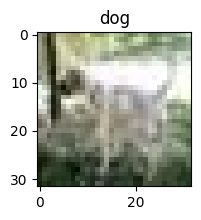

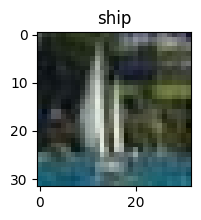

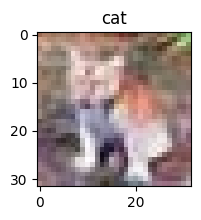

In [45]:
for i in range(4):
    plt.figure(figsize=(2, 2))
    plt.title(index2label[np.where(y_test[i] == 1)[0][0]])
    # plt.imshow(X[i].reshape(32, 32))
    plt.imshow(X_test[i])
    plt.show()

In [ ]:
# train_dataset, valid_dataset, test_dataset

### __`MODEL`__

- https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
- https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy
- https://keras.io/api/layers/regularization_layers/dropout/

In [26]:
def create_NN(n_hidden_: list, activation: list, optimizer=optimizers.SGD, learning_rate=0.1) -> Sequential:
    model = Sequential(name=f'''m-{''.join(map(str, [f'{i}-' for i in n_hidden_[1:-1]]))}{''.join(map(str, [f'{a}-' for a in activation[:-1]]))}{optimizer.__name__}-{learning_rate}''')
    n_layers = len(n_hidden_)
    for layer in range(1, n_layers):
        model.add(Dense(n_hidden_[layer], activation=activation[layer-1], input_shape=(n_hidden_[layer-1],)))
        # model.add(Dropout(.5)) if layer + 1 != n_layers else None # 0.5 Fraction of the input units to drop.

    model.compile(
                  optimizer=optimizer(learning_rate=learning_rate), # legacy
                  loss=losses.CategoricalCrossentropy(),  # 'categorical_crossentropy' losses.binary_crossentropy,
                  metrics=['accuracy', metrics.CategoricalAccuracy()]  # metrics.BinaryAccuracy()  metrics.CategoricalAccuracy()  or metrics.Accuracy()?
                  )

    return model

#### __`Training`__

In [27]:
def draw_2twin_2d(y00: np.array, y01: np.array, y10: np.array, y11: np.array, suptitle: str) -> None:
    x = range(1, len(y00) + 1)
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 8))

    axs[0].plot(x, y00, 'bo', label='Training loss')
    axs[0].plot(x, y01, 'g', label='Validation loss')
    axs[0].title.set_text('Training and validation loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid()

    axs[1].plot(x, y10, 'bo', label='Training acc')
    axs[1].plot(x, y11, 'g', label='Validation acc')
    axs[1].title.set_text('Training and validation acc')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Acc')
    axs[1].legend()
    axs[1].grid()
    
    fig.suptitle(suptitle)
    # plt.legend()
    # plt.grid()
    plt.show()

In [ ]:
# print(history[0].history.keys())
""" 
loss - список, в якому зберігається історія змін помилки на навчальних даних залежно від епохи
val_loss - список, де зберігається історія змін помилки на тестових даних залежно від епохи
accuracy - список, в якому зберігається історія змін точності на навчальних даних залежно від епохи
val_accuracy - список, де зберігається історія змін точності на тестових даних залежно від епохи
"""

- https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
- https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

In [28]:
callback_early_stopping = EarlyStopping(
                                        monitor='val_categorical_accuracy',  # val_loss
                                        patience=4,
                                        )

callback_save = ModelCheckpoint(
                                'best.hdf5',  # name to save the resulting model
                                monitor='val_loss',
                                save_best_only=True,
                                )

In [29]:
def test_NN(
            train_dataset: Dataset, 
            valid_dataset: Dataset, 
            set_layers: list, 
            act: list, 
            opt: optimizers, 
            lr: float,  
            epochs: int=100
            ) -> None:
    """For test one model."""
    model = create_NN(
                      n_hidden_=set_layers, 
                      activation=act, 
                      optimizer=opt, 
                      learning_rate=lr
                      )

    history = model.fit(
                        train_dataset,
                        validation_data=valid_dataset,
                        epochs=epochs,
                        verbose=1, # print logs
                        callbacks=[callback_early_stopping]  # callback_save
                        )

    loss_values = history.history['loss']
    val_loss_values = history.history['val_loss']
    acc_values = history.history['categorical_accuracy']
    val_acc_values = history.history['val_categorical_accuracy']   

    draw_2twin_2d(loss_values, val_loss_values, acc_values, val_acc_values, suptitle=f'{model.name}({train_dataset.batch_size})')

In [30]:
train_dataset.batch_size

256

Epoch 1/100
15/15 [==============================] - 2s 94ms/step - loss: 222.3452 - accuracy: 0.1133 - categorical_accuracy: 0.1133 - val_loss: 48.8268 - val_accuracy: 0.1328 - val_categorical_accuracy: 0.1328
Epoch 2/100
15/15 [==============================] - 1s 37ms/step - loss: 30.4226 - accuracy: 0.1344 - categorical_accuracy: 0.1344 - val_loss: 18.6894 - val_accuracy: 0.1771 - val_categorical_accuracy: 0.1771
Epoch 3/100
15/15 [==============================] - 1s 35ms/step - loss: 13.7550 - accuracy: 0.1706 - categorical_accuracy: 0.1706 - val_loss: 12.5812 - val_accuracy: 0.1562 - val_categorical_accuracy: 0.1562
Epoch 4/100
15/15 [==============================] - 1s 36ms/step - loss: 10.4520 - accuracy: 0.1602 - categorical_accuracy: 0.1602 - val_loss: 9.2630 - val_accuracy: 0.1810 - val_categorical_accuracy: 0.1810
Epoch 5/100
15/15 [==============================] - 1s 35ms/step - loss: 8.8113 - accuracy: 0.1698 - categorical_accuracy: 0.1698 - val_loss: 8.8033 - val_accu

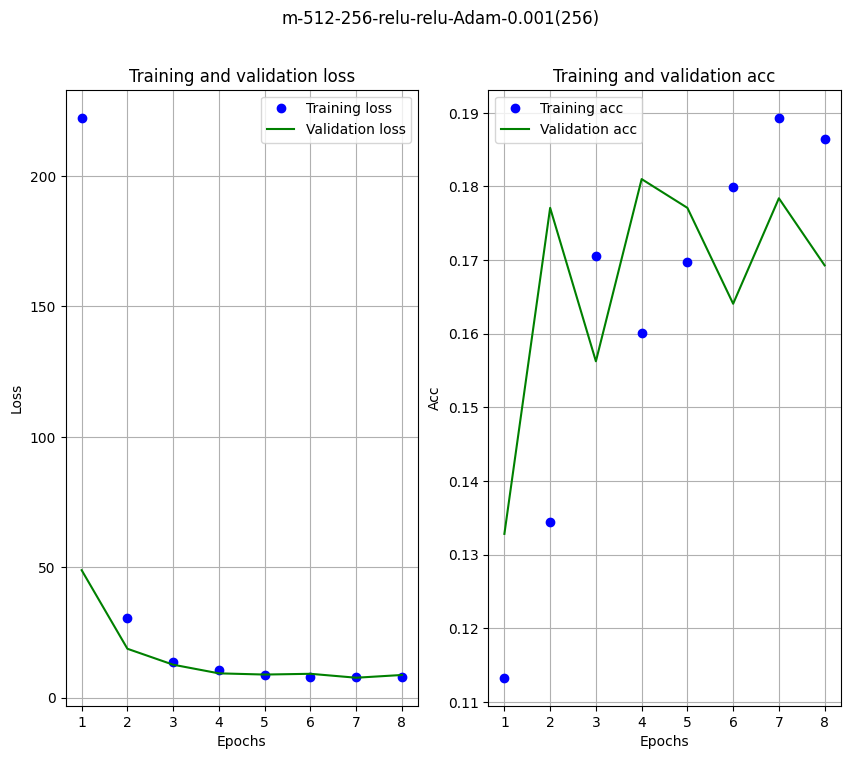

In [31]:
test_NN(
        train_dataset=train_dataset,
        valid_dataset=valid_dataset,
        set_layers=[NUM_FEATURES, 512, 256, NUM_CLASSES], 
        act=['relu', 'relu', 'softmax'], 
        opt=optimizers.legacy.Adam, 
        lr=0.001,
        epochs=100
        )

### __`INTERPRET`__ / __`Error Analysis`__

In [ ]:
# draw

### __`RE-TEST`__

In [ ]:
# deploy...

### __`RESULTS` & `CONCLUSIONS`__